In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
ABC_ab = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
ABC_ab = preprocess_seqs(ABC_ab, "Y").sort_values(by="Protein")

data_ab = ABC_ab.select_dtypes(include=['float64']).T
info_ab = ABC_ab.select_dtypes(include=['object'])

treatments_ab = ["PC9", "Knock-Out", "Kin. Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
data_ab.index = treatments_ab

In [4]:
ABC_ab

,Protein,Sequence,UniprotAcc,Abbv,Position,BioReps,r2_Std,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
0,26S proteasome regulatory subunit 4,DKKKKyEPPVP,P62191,PSMC1,Y25-p,1,N/A,-0.108045,-0.476332,-0.321637,-0.239781,0.126419,0.274226,0.243800,0.210842,0.326859,-0.036352
1,40S ribosomal protein S10,NRIAIyELLFK,P46783,RPS10,Y12-p,1,N/A,-0.169514,0.097204,-1.712342,0.173058,0.152218,-0.295116,0.846713,1.092283,-0.347285,0.162782
2,40S ribosomal protein SA,LTEASyVNLPT,P08865,RPSA,Y139-p,1,N/A,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
3,ARF GTPase-activating protein GIT1,DDQHDyDSVAS,Q9Y2X7,GIT1,Y383-p,1,N/A,0.670858,0.718143,0.225202,-0.528652,-0.461699,-0.161058,0.103659,-0.139631,-0.028111,-0.398711
4,ATPase WRNIP1,AGEEHyNCISA,Q96S55,WRNIP1,Y500-p,1,N/A,0.242877,0.226631,-0.140038,-0.402742,-0.033013,0.011860,0.085925,0.126432,-0.122947,0.005017
5,Abl interactor 1,TVPNDyMTSPA,Q8IZP0,ABI1,Y213-p,1,N/A,0.273062,-0.187348,-0.062648,0.256941,-0.208152,-0.061496,-0.029967,0.380140,-0.173045,-0.187487
6,Abl interactor 2,VVPNDyVPSPT,Q9NYB9,ABI2,Y213-p,1,N/A,0.721179,-1.069889,-0.432169,0.246437,0.267770,0.015784,0.185314,0.205212,0.087689,-0.227328
7,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,Q8N4X5,AFAP1L2,Y56-p,1,N/A,-0.147154,-0.552185,-0.143250,0.188582,-0.079832,0.259525,0.229806,0.005517,0.376333,-0.137342
8,Actin filament-associated protein 1-like 2,SSDEEyIYMNK,Q8N4X5,AFAP1L2,Y54-p,1,N/A,0.560018,0.167027,-0.372270,0.249165,-0.039186,0.017801,-0.131200,-0.080767,-0.181592,-0.188995
9,Actin filament-associated protein 1-like 2,SSDEEyIyMNK,Q8N4X5,AFAP1L2,Y54-p,1,N/A,0.590098,0.677838,-0.251106,0.181362,-0.289120,-0.381727,0.057495,-0.319723,0.110845,-0.375963


### Phenotypes

#### Cell Viability of AXL mutant Cell Lines

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR1.csv").iloc[:, 1:]
cv1_ab = cv1.loc[:, cv1.columns.str.contains('-A/E')]
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR2.csv').iloc[:, 1:]
cv2_ab = cv2.loc[:, cv2.columns.str.contains('-A/E')]
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR3.csv').iloc[:, 1:]
cv3_ab = cv3.loc[:, cv2.columns.str.contains('-A/E')]

for ii in range(0, cv2_ab.columns.size):
    cv1_ab.iloc[:, ii] /= cv1_ab.iloc[0, ii]
    cv2_ab.iloc[:, ii] /= cv2_ab.iloc[0, ii]
    cv3_ab.iloc[:, ii] /= cv3_ab.iloc[0, ii]

cv = pd.concat([cv1_ab, cv2_ab, cv3_ab], axis=0)
cv.insert(0, "Elapsed",  cv1.iloc[:, 0])
cv =  MergeDfbyMean(cv, cv1_ab.columns, "Elapsed").reset_index()
CV_ab = cv[cv["Elapsed"] == 120].iloc[0, 1:]
CV_ab = CV_ab[["PC9-A/E", "AXL KO-A/E", "Kdead-A/E", "Kin-A/E", "M4-A/E", "M5-A/E", "M7-A/E", "M10-A/E", "M11-A/E", "M15-A/E"]]

CV_ab

PC9-A/E       10.661811
AXL KO-A/E     2.814789
Kdead-A/E      4.405414
Kin-A/E        8.185261
M4-A/E         6.530231
M5-A/E         6.613370
M7-A/E         9.819472
M10-A/E        9.154419
M11-A/E        9.981410
M15-A/E        6.105206
Name: 40, dtype: float64

# Chained MS mixed clustering + PLSR analysis

### + Erlotinib + AF154

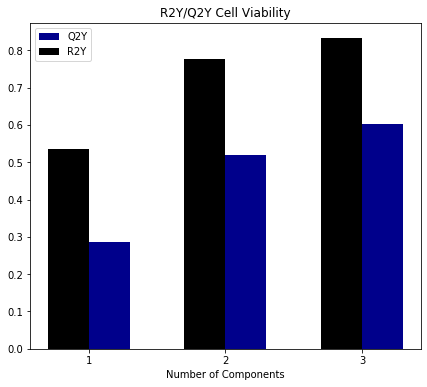

In [6]:
distance_method = "Binomial"
ncl = 5
GMMweight = 0.0

MSC = MassSpecClustering(info_ab, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data_ab, CV_ab)
centers_ab = MSC.transform(data_ab)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, centers_ab, CV_ab, 4)

In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data_ab, info_ab, CV_ab, distance_method)

In [8]:
# CVresults_max, CVresults_min, best_params = MSclusPLSR_tuning(data_ab, info_ab, CV_ab, distance_method)

In [9]:
# ncl_GMMweight_ncomp = CVresults_min.sort_values(by="Ranking").iloc[:21, :]
# ncl_GMMweight_ncomp

In [10]:
# create_download_link(ncl_GMMweight_ncomp, "20200119-AxlMutants_GridSearch_PAM250_ErlAF154")

In [11]:
# labels = []
# for ii in range(ncl_GMMweight_ncomp.shape[0]):
#     labels.append(str(ncl_GMMweight_ncomp.iloc[ii, 1]) + 
#                   "|" + str(ncl_GMMweight_ncomp.iloc[ii, 2]) + 
#                   "|" + str(ncl_GMMweight_ncomp.iloc[ii, 3]))

    
# fig, ax = plt.subplots(1,1,figsize=(25,10))

# width = 0.5
# ax.bar(np.arange(ncl_GMMweight_ncomp.shape[0]), np.abs(ncl_GMMweight_ncomp.iloc[:, 4]), width, edgecolor='black', color='g')
# ax.set_xticks(np.arange(ncl_GMMweight_ncomp.shape[0]))
# ax.set_xticklabels(labels, fontsize=12)
# ax.set_xlabel("#Clusters | #Components | GMM Weight", fontsize=16)
# ax.set_ylabel("Mean-Squared Error (MSE)", fontsize=16)
# ax.set_title("Top20 Hyperparameter Combinations", fontsize=20)

In [12]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info_ab, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data_ab, CV_ab)
centers_ab = mixedCl_plsr.named_steps.mixedCl.transform(data_ab)

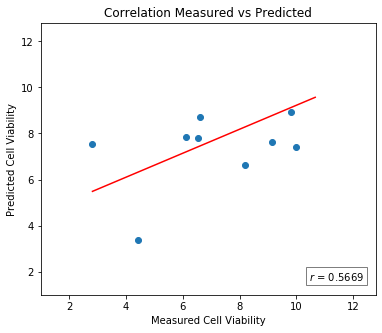

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data_ab, CV_ab)

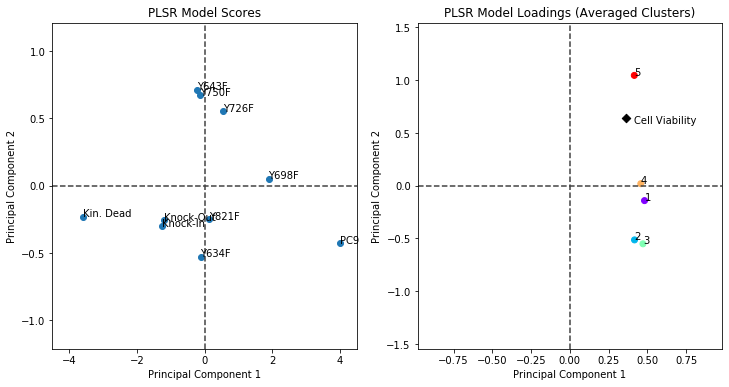

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers_ab, CV_ab, ncl, treatments_ab)

In [15]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC_ab.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

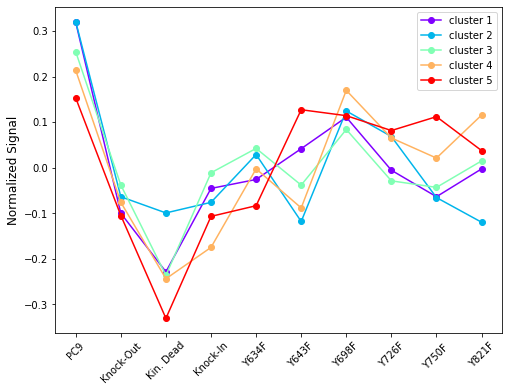

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, centers_ab.T, treatments_ab)

In [17]:
clustermembers

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,UniprotAcc_C2,Pos_C2,r2/Std_C2,BioReps_C2,Prot_C3,abbv_C3,seqs_C3,UniprotAcc_C3,Pos_C3,r2/Std_C3,BioReps_C3,Prot_C4,abbv_C4,seqs_C4,UniprotAcc_C4,Pos_C4,r2/Std_C4,BioReps_C4,Prot_C5,abbv_C5,seqs_C5,UniprotAcc_C5,Pos_C5,r2/Std_C5,BioReps_C5
0,40S ribosomal protein S10,RPS10,NRIAIyELLFK,P46783,Y12-p,N/A,1,ARF GTPase-activating protein GIT1,GIT1,DDQHDyDSVAS,Q9Y2X7,Y383-p,N/A,1,26S proteasome regulatory subunit 4,PSMC1,DKKKKyEPPVP,P62191,Y25-p,N/A,1,Annexin A1,ANXA1,DARALyEAGER,P04083,Y207-p,0.85,2,Catenin delta-1,CTNND1,GGSDNyGSLSR,O60716,Y228-p,N/A,1
1,"Actin, cytoplasmic 1",ACTB,KEKLCyVALDF,P60709,Y218-p,N/A,1,Abl interactor 1,ABI1,TVPNDyMTSPA,Q8IZP0,Y213-p,N/A,1,40S ribosomal protein SA,RPSA,LTEASyVNLPT,P08865,Y139-p,N/A,1,Annexin A1,ANXA1,SAVSPyPTFNP,P04083,Y39-p,N/A,1,Catenin delta-1,CTNND1,FHPEPyGLEDD,O60716,Y280-p,N/A,1
2,Adapter molecule crk,CRK,QEEAEyVRALF,P46108,Y136-p,0.51,2,Abl interactor 2,ABI2,VVPNDyVPSPT,Q9NYB9,Y213-p,N/A,1,ATPase WRNIP1,WRNIP1,AGEEHyNCISA,Q96S55,Y500-p,N/A,1,"Asparagine--tRNA ligase, cytoplasmic",NARS1,RDVCLyPRFVQ,O43776,Y539-p,N/A,1,Desmoplakin,DSP,EKsAIyQLEEE,P15924,Y249-p,N/A,1
3,Alpha-actinin-1,ACTN1,PELIDyGKLRK,P12814,Y193-p,N/A,1,Adapter molecule crk,CRK,RVPNAyDKTAL,P46108,Y251-p,N/A,1,Actin filament-associated protein 1-like 2,AFAP1L2,DEEYIyMNKVT,Q8N4X5,Y56-p,N/A,1,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1,BAIAP2L1,KDGWLyGEHDV,Q9UHR4,Y380-p,N/A,1,Enhancer of filamentation 1,NEDD9,EYPSRyQKDVY,Q14511,Y172-p,0.52,2
4,Annexin A5,ANXA5,RLYDAyELKHA,P08758,Y94-p,N/A,1,Alpha-actinin-1,ACTN1,DVAEKyLDIPK,P12814,Y215-p,N/A,1,Actin filament-associated protein 1-like 2,AFAP1L2,SSDEEyIYMNK,Q8N4X5,Y54-p,N/A,1,Breast cancer anti-estrogen resistance protein 1,BCAR1,LAKALyDNVAE,P56945,Y12-p,N/A,1,Focal adhesion kinase 1,PTK2,FGLSRyMEDST,Q05397,Y570-p,0.85,2
5,BAG family molecular chaperone regulator 3,BAG3,AQQGEyQTHQP,O95817,Y240-p,N/A,1,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1,BAIAP2L1,VVRKDyDTLSK,Q9UHR4,Y274-p,N/A,1,Actin filament-associated protein 1-like 2,AFAP1L2,SSDEEyIyMNK,Q8N4X5,Y54-p,N/A,1,Caveolae-associated protein 1,CAVIN1,PDHVVyARSKT,Q6NZI2,Y308-p,0.2,3,Focal adhesion kinase 1,PTK2,FGLSRyMEDsT,Q05397,Y570-p,N/A,1
6,Band 4.1-like protein 1,EPB41L1,IRPGEyEQFES,Q9H4G0,Y343-p,N/A,1,Calmodulin-1,CALM1,KDGNGyISAAE,P0DP23,Y100-p,N/A,1,Actin-binding LIM protein 3,ABLIM3,ARsSSyADPWT,O94929,Y538-p,N/A,1,Cofilin-1,CFL1,TVDDPyATFVK,P23528,Y68-p,N/A,1,G-protein coupled receptor family C group 5 member B,GPRC5B,FRsNVyQPTEM,Q9NZH0,Y376-p,N/A,1
7,Brain-specific angiogenesis inhibitor 1-associated protein 2,BAIAP2,KLSDSySNTLP,Q9UQB8,Y337-p,N/A,1,Crk-like protein,CRKL,RVPCAyDKTAL,P46109,Y251-p,N/A,1,Actin-related protein 2/3 complex subunit 3,ARPC3,VDEAIyYFKAN,O15145,Y47-p,0.73,2,Elongation factor 1-alpha 1,EEF1A1,TGHLIyKCGGI,P68104,Y29-p,N/A,1,Glucose-6-phosphate 1-dehydrogenase,G6PD,EGRGGyFDEFG,P11413,Y249-p,N/A,1
8,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1,BAIAP2L1,HKEIEyVETVT,Q9UHR4,Y163-p,N/A,1,Disks large homolog 3,DLG3,VDGQDyHFVVS,Q92796,Y673-p,0.3,4,Annexin A2,ANXA2,GKsLYyYIQQD,P07355,Y317-p,N/A,1,Epidermal growth factor receptor kinase substrate 8-like protein 1,EPS8L1,EGARVySQVTV,Q8TE68,Y684-p,N/A,1,"Keratin, type I cytoskeletal 18",KRT18,DRLASyLDRVR,P05783,Y94-p,0.5,2
9,Breast cancer anti-estrogen resistance protein 1,BCAR1,GQGYVyEAAQP,P56945,Y224-p,N/A,1,"Dynein light chain 1, cytoplasmic",DYNLL1,RNFGSyVTHET,P63167,Y65-p,N/A,1,Annexin A2,ANXA2,KsYSPyDMLES,P07355,Y238-p,0.29,4,Eukaryotic translation initiation factor 2 subunit 2,EIF2S2,KDTRLyFLQCE,P20042,Y298-p,N/A,1,L-lactate dehydrogenase A chain,LDHA,SARFRyLMGER,P00338,Y172-p,N/A,1
